<a href="https://colab.research.google.com/github/patrickzoechbauer/beyondmcmc/blob/main/HierRegSim.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Section 0: Install numpyro as well as RAABBVI 

In [ ]:
!pip install numpyro
!pip install pystan==2.19.1.1
!pip install git+https://github.com/Manushi22/viabel

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 291 kB 15.1 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 67.3 MB 99 kB/s 
  Attempting uninstall: pystan
    Found existing installation: pystan 3.3.0
    Uninstalling pystan-3.3.0:
      Successfully uninstalled pystan-3.3.0
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/Manushi22/viabel to /tmp/pip-req-build-7uc33e_i
  Running command git clone -q https://github.com/Manushi22/viabel /tmp/pip-req-build-7uc33e_i
     |████████████████████████████████| 41 kB 206 kB/s 
  Created wheel for viabel: filename=viabel-0.4.2-py3-none-any.whl size=40398 sha256=fde0aebbd21da01e5a175b347427168e90cd480f83cf32d7c77b7eb482a546b4
  Stored in directory: /tmp/pip-ephem-wheel-cache-zpxuf_ph

In [ ]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import scipy.stats
import random
import time
import pickle

import numpyro
from numpyro.infer import MCMC, NUTS, SVI, Predictive, Trace_ELBO, autoguide
import numpyro.distributions as dist

import jax.numpy as jnp
from jax.random import PRNGKey

from scipy.stats import multivariate_normal
from scipy.stats import genpareto
from scipy.stats import wasserstein_distance
from scipy.stats import ks_2samp

import viabel
from viabel.optimization import FASO, RMSProp, RAABBVI
from viabel.objectives import ExclusiveKL
from viabel.approximations import MFGaussian
from viabel.models import Model
from viabel import bbvi, MFStudentT
from viabel.diagnostics import all_diagnostics 

import arviz

from tqdm.notebook import tqdm, trange
import os, sys

# Section 1: Define functions to train MCMC, ADVI and RAABBVI

In [ ]:
class HiddenPrints:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')

    def __exit__(self, exc_type, exc_val, exc_tb):
        sys.stdout.close()
        sys.stdout = self._original_stdout

In [ ]:
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
  
set_seed(1)

In [ ]:
def sample_data(N=8):
  mu = 2
  tau = 1
  logsigma = np.random.normal(loc = 0, scale = 1, size = (N,))
  sigma = np.exp(logsigma)

  theta = np.random.normal(loc = mu, scale = tau, size = (N,))
  y = np.random.normal(loc = theta, scale = sigma, size = (N,))

  return y, sigma, theta, mu, tau

In [ ]:
# Defines probabilistc model for numpyro
def model(X, Y=None):

  N = sigma.shape[0]
  mu = numpyro.sample('mu', dist.Normal(0, 5))
  logtau = numpyro.sample('logtau', dist.Normal(0,5))

  with numpyro.plate('N', N):
    theta = numpyro.sample('theta', dist.Normal(mu, jnp.exp(logtau)))
    numpyro.sample('obs', dist.Normal(theta, X), obs=Y)

In [ ]:
# Functions to run VI using RAAABBVI
def log_density(theta):  
    import autograd.numpy as np
    import autograd.scipy.stats.norm as norm
    import autograd.scipy.stats.gamma as gamma

    mu_q, log_tau_q, theta_q = theta[:,0], theta[:, 1], theta[:,2:]

    #Priors: 
    mu_q = mu_q.mean(axis = 0).squeeze()
    log_tau_q = log_tau_q.mean(axis = 0).squeeze()
    theta_q = theta_q.mean(axis = 0).squeeze()

    #likelihood 
    y_density = np.sum(norm.logpdf(y, theta_q, sigma))
    theta_density = np.sum(norm.logpdf(theta, mu_q, np.exp(log_tau_q)))
    mu_density = np.sum(norm.logpdf(mu_q, 0, 5))
    tau_density = np.sum(norm.logpdf(log_tau_q, 0,5))
    tau_density += log_tau_q #jacobian term

    return y_density + theta_density + mu_density + tau_density

def raabbvi(dimension, n_iters=10000, num_mc_samples=10, log_density=None, 
            learning_rate=0.1, RMS_kwargs={'diagnostics':True}, FASO_kwargs=dict()):
    """Fit a model using black-box variational inference.
    """
    model = Model(log_density)
    approx = MFGaussian(dimension)
    objective = ExclusiveKL(approx, model, num_mc_samples)
    init_var_param = approx.init_param()

    base_opt = RMSProp(learning_rate, **RMS_kwargs)
    #opt = FASO(base_opt, **FASO_kwargs)
    opt = RAABBVI(base_opt, **FASO_kwargs)

    opt_results = opt.optimize(n_iters, objective, init_var_param)
    opt_results['objective'] = objective
    return opt_results, approx

In [ ]:
# Function to run MCMC with NUTS sampler
def run_mcmc(model, num_warmup, num_samples, num_chains, X, Y, summary = False):
    kernel = NUTS(model)
    mcmc = MCMC(
        kernel,
        num_warmup=num_warmup,
        num_samples=num_samples,
        num_chains=num_chains,
    )
    mcmc.run(PRNGKey(1), X, Y)
    if summary:
      mcmc.print_summary()
    return mcmc.get_samples()

In [ ]:
# Function to calculate PSIS for numpyro VI approx 
def calcPSIS(vi_guide, vi_params):
  #Step 3: Get samples \theta_s for s = 1,...,S
  S = 10000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  theta = np.c_[samples_vi['mu'].to_py(),
                samples_vi['logtau'].to_py(),
                samples_vi['theta'].to_py()]

  #Step 4: Calcualte the importance ratio

  #calc log(p(\theta_s, y))
  #lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['y'].sum(axis = 1)

  lp_target = log_density(theta)
  #lp_target += np.log(samples_vi['sigma'].to_py())
  ###log(sigma) is the jacobian term in the joint density using log(sigma) as the transformed parameters.

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2
  #check if vi_cov singular
  det = np.linalg.det(vi_cov)
  if det < 0.00001:
      return 10
 
  var = multivariate_normal(mean=vi_mean, 
                            cov=vi_cov,
                            allow_singular=True)
  lp_vi = var.logpdf(theta)

  # calc the ratio
  lp_ratio = lp_target-lp_vi

  # Step 5: 
  #select largest M of lp_ratio
  M = int(np.min([S/5, 3*np.sqrt(S)]))
  log_rs_largest = np.partition(lp_ratio,-M)[-M:]

  _, k = arviz.psislw(log_rs_largest, 0.6)

  return k

In [ ]:
def H2(log_weights, alpha=2.):
  log_weights = np.asarray(log_weights)
  log_rescale = np.max(log_weights)

  rescaled_weights = np.exp(log_weights - log_rescale)**alpha
  mean_rescaled_weight = np.mean(rescaled_weights)
  cubo = np.log(mean_rescaled_weight) / alpha + log_rescale
  log_norm_bound = np.mean(log_weights)
  dalpha = alpha / (alpha - 1) * (cubo - log_norm_bound)
  return dalpha  

def WSBoundExpInt(log_weights, samples, p=1):
  d2 = H2(log_weights)
  epsilon = 1
  integral = np.log(np.mean(np.exp(epsilon*d2**p)))
  Cp = 2*((1/epsilon)*(3/2 + integral))**(1/p)
  bound = Cp*(d2**(1/p)+(d2*0.5)**(1/(2*p)))
  return {'W'+str(p):bound}

In [ ]:
def VIbounds(vi_guide, vi_params, expBound = False):
  S = 2000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))
  sample_vi_transform = np.c_[np.log(samples_vi['sigma'].to_py()), 
                                      samples_vi['beta'].to_py()]

  #Step 4: Calcualte the importance ratio
  #calc log(p(\theta_s, y))
  lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['y'].sum(axis = 1)
  lp_target += np.log(samples_vi['sigma'].to_py())

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2

  var = multivariate_normal(mean=vi_mean, 
                              cov=vi_cov)
  lp_vi = var.logpdf(sample_vi_transform)

  # calc the ratio
  log_weights = lp_target-lp_vi
  samples = sample_vi_transform

  if expBound == True: 
    bounds = WSBoundExpInt(log_weights, samples, p=2)
  else: 
    bounds = all_diagnostics(log_weights, samples = samples)

  return bounds

In [ ]:
def AnalyticalW2Bound(vi_params, vi_guide):
  #Calc C_2
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd
  vi_cov = np.matmul(vi_cov, vi_cov)
  #lambdas = np.linalg.eig(vi_cov)[0]
  epsilon = 0.1
  C = 2*((1/epsilon)*((3/2)+np.log((1-2*epsilon)**(-0.5)).sum()))**0.5

  #Approx. KL-divergence
  S = 2000
  samples_vi = vi_guide.sample_posterior(PRNGKey(1), vi_params, (S,))

  theta = np.c_[samples_vi['mu'].to_py(),
                samples_vi['logtau'].to_py(),
                samples_vi['theta'].to_py()]

  lp_target = log_density(theta)

#  sample_vi_transform = np.c_[np.log(samples_vi['sigma'].to_py()), 
#                                      samples_vi['beta'].to_py()]

  #calc log(p(\theta_s, y))
#  lp_target = numpyro.infer.log_likelihood(model, samples_vi, X, y)['y'].sum(axis = 1)
#  lp_target += np.log(samples_vi['sigma'].to_py())

  # calc log(q(\theta_s))
  vi_mean = vi_params['auto_loc'].to_py()
  vi_sd = vi_params['auto_loc'].to_py()
  vi_cov = np.eye(vi_mean.shape[0])*vi_sd**2
  #check if vi_cov singular
  var = multivariate_normal(mean=vi_mean, 
                            cov=vi_cov,
                            allow_singular=True)
  lp_vi = var.logpdf(theta)

  # calc the ratio
  log_weights = lp_target-lp_vi

  d2 = H2(log_weights)
  p=2
  bound = C*(d2**(1/p)+(d2*0.5)**(1/(2*p)))

  return {'W2':bound}

In [ ]:
# Function to run ADVI with mean-field approximation
# Stopping criteria is based on relative improvement of ELBO as in Stan
from arviz.stats.diagnostics import rhat
def run_ADVI(model, guide_family, maxiter, X, Y, stopping = 'ELBO', tol = 10**(-2)):
    if guide_family == "AutoDelta":
        guide = autoguide.AutoDelta(model)
    elif guide_family == "AutoDiagonalNormal":
        guide = autoguide.AutoDiagonalNormal(model)

    optimizer = numpyro.optim.Adam(0.1)
    svi = SVI(model, guide, optimizer, Trace_ELBO(num_particles=100))
 
    svi_state = svi.init(PRNGKey(1), X=X, Y=Y)
    losses = []
    loss_old = 1
    W2old = 1

    pbar = tqdm(range(maxiter))

    t0 = time.time()
    for i in pbar:
      svi_state, loss_new = svi.update(svi_state, X=X, Y=Y)
      rel_err = jnp.abs((1-loss_new/loss_old))
        
      loss_old = loss_new
      losses.append(loss_new)
      
      if stopping == 'ELBO':
        if rel_err < tol: 
          print('Stopped after {} iterations with default tol of {}.'.format(i+1, tol))
          break
      if stopping == 'PSIS':
        params = svi.get_params(svi_state)
        k =  calcPSIS(guide, params)
        pbar.set_postfix({'k': k})
        if k < 0.8: 
          print('Stopped after {} iterations because k = {:.2f}.'.format(i+1, k))
          break
      if stopping == 'wasserstein':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        rel_W2 = jnp.abs((1-bounds['W2']/W2old))

        pbar.set_postfix({'RelW2': rel_W2, 'W2':bounds['W2']})
        W2old = bounds['W2']
        #print(rel_W2)
        if rel_W2 < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break        

      if stopping == 'wasserstein_abs':
        params = svi.get_params(svi_state)
        #bounds = VIbounds(guide, params, expBound = True)
        bounds = AnalyticalW2Bound(params, guide)
        pbar.set_postfix({'W2':bounds['W2']})
        if bounds['W2'] < tol:
          print('Stopped after {} iterations with W2 tol of {}.'.format(i+1, tol))
          break   

      if stopping == 'time':
        trun = time.time()-t0
        if trun > tol:
          print('Stopped after {} iterations with time tol of {}.'.format(i+1, tol))
          break

      W = 50
      if stopping == 'rhat':
        params = svi.get_params(svi_state)      
        if i == 0: 
          loc = params['auto_loc']
          dim = loc.shape[0]
        else:
          loc = np.c_[loc, params['auto_loc']]
          #scale = np.c_[scale, params['auto_scale']]
        if i > 2*W:
          rhat_array = []
          for l in range(dim):
            locl = loc[l,:]
            k = i-2*W
            chain = np.stack((locl[k:k+W],locl[k+W:k+2*W]))
            rhat_array.append(rhat(chain))
          
          if np.mean(rhat_array) < 2:
            print('Stopped after {} iterations with rhat of {}.'.format(i+1, tol))
            break


    losses = jnp.stack(losses)
    params = svi.get_params(svi_state)

    return losses, params, guide

In [ ]:
# Plot posterior distriutions against ground truth
def plotResults(locLegend):
  samples_mcmc = np.c_[posterior_samples['mu'].to_py(), 
                       posterior_samples['logtau'].to_py() ]

  samples_vi = np.c_[vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['mu'].to_py(),
                     vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['logtau'].to_py()]                    

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)
  samples_raabbvi = samples_raabbvi[:,0:2]

  cols_used = ['$\mu$', r'$\log(\tau)$']

  fig, ax = plt.subplots(figsize=(4,3))
  labels = []

  v1 = ax.violinplot(
      [samples_mcmc[:, i] for i in range(len(cols_used))]
      )
  c1 = v1['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c1), 'MCMC'))

  v2 = ax.violinplot(
      [samples_vi[:, i] for i in range(len(cols_used))]
      )
  c2 = v2['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c2), 'ADVI'))

  v3 = ax.violinplot(
      [samples_raabbvi[:, i] for i in range(len(cols_used))]
      )
  c3 = v3['bodies'][0].get_facecolor().flatten()
  labels.append((mpatches.Patch(color=c3), 'RAABBVI'))

  #add ground truth
  ground_truth = [mu, np.log(tau)]
  for i in range(len(cols_used)):
    ax.hlines(y=ground_truth[i], xmin=(i+1)-0.1, xmax=(i+1)+0.1, linewidth=2, color='r')

  ax.set_xticks(np.arange(1, len(cols_used) + 1))
  ax.set_xticklabels(cols_used, rotation=45, fontsize=10)
  ax.legend(*zip(*labels), loc=locLegend)
  plt.title("Hierarchical model")

In [ ]:
# Performance on the mean:
def MADstats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.mean(axis = 0)
  MAD_mu = np.abs((samples - groundTruth)).mean(axis = 0)
  MAD_beta_mu = MAD_mu[0]
  MAD_sigma_mu = MAD_mu[1]
  return [MAD_beta_mu], [MAD_sigma_mu]   

def varianceStats(samples, samplesMCMC, D):
  groundTruth = samplesMCMC.std(axis = 0)
  samplesStd = samples.std(axis = 0)
  MAD_std = np.abs((samplesStd-groundTruth))
  MAD_beta_std = MAD_std[0]
  MAD_sigma_std = MAD_std[1]
  return [MAD_beta_std], [MAD_sigma_std]

def getPerformance(D):
  samples_mcmc = np.c_[posterior_samples['mu'].to_py(), 
                       posterior_samples['logtau'].to_py()]

  samples_vi = np.c_[vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['mu'].to_py(),
                     vi_guide.sample_posterior(PRNGKey(1), vi_params, (2000,))['logtau'].to_py()]                    

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                       n_samples = 2000)
  
  samples_raabbvi = samples_raabbvi[:, 0:2] 

  # Calculate mean performance:

  MAD_advi_beta_mu, MAD_advi_sigma_mu = MADstats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_mu, MAD_raabbvi_sigma_mu = MADstats(samples_raabbvi, samples_mcmc, D)

  result_mu = {('mu', 'advi'): MAD_advi_beta_mu,
            ('logtau', 'advi'): MAD_advi_sigma_mu,
            ('mu', 'raabbvi'): MAD_raabbvi_beta_mu,
            ('logtau', 'raabbvi'): MAD_raabbvi_sigma_mu}

  resDf_mu = pd.DataFrame(result_mu)

  # Calculate std performance:

  MAD_advi_beta_std, MAD_advi_sigma_std = varianceStats(samples_vi, samples_mcmc, D)
  MAD_raabbvi_beta_std, MAD_raabbvi_sigma_std = varianceStats(samples_raabbvi, samples_mcmc, D)

  result_std = {('mu', 'advi'): MAD_advi_beta_std,
              ('logtau', 'advi'): MAD_advi_sigma_std,
              ('mu', 'raabbvi'): MAD_raabbvi_beta_std,
              ('logtau', 'raabbvi'): MAD_raabbvi_sigma_std}

  resDf_std = pd.DataFrame(result_std)

  # Calculate wasserstein distance: 

  W_mu_advi = wasserstein_distance(samples_mcmc[:,0], samples_vi[:,0])
  W_mu_raabbvi = wasserstein_distance(samples_mcmc[:,0], samples_raabbvi[:,0])

  W_logtau_advi = wasserstein_distance(samples_mcmc[:,1], samples_vi[:,1])
  W_logtau_raabbvi = wasserstein_distance(samples_mcmc[:,1], samples_raabbvi[:,1])

  result_W = {('mu', 'advi'): [W_mu_advi],
              ('logtau', 'advi'): [W_logtau_advi],
              ('mu', 'raabbvi'): [W_mu_raabbvi],
              ('logtau', 'raabbvi'): [W_logtau_raabbvi]}

  resDf_W = pd.DataFrame(result_W)

  # Calculate KS-test p-value

  _, KS_mu_advi = ks_2samp(samples_mcmc[:,0], samples_vi[:,0])
  _, KS_logtau_advi = ks_2samp(samples_mcmc[:,1], samples_vi[:,1])

  _, KS_mu_raabbvi = ks_2samp(samples_mcmc[:,0], samples_raabbvi[:,0])
  _, KS_logtau_raabbvi = ks_2samp(samples_mcmc[:,1], samples_raabbvi[:,1])

  result_KS = {('mu', 'advi'): [KS_mu_advi],
              ('logtau', 'advi'): [KS_logtau_advi],
              ('mu', 'raabbvi'): [KS_mu_raabbvi],
              ('logtau', 'raabbvi'): [KS_logtau_raabbvi]}

  resDf_KS = pd.DataFrame(result_KS)

  return resDf_mu, resDf_std, resDf_W, resDf_KS

# Section 2: Run MCMC, ADVI and RAABBVI on sample data

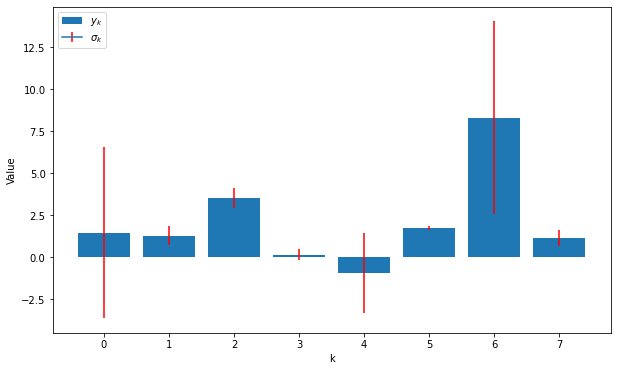

In [ ]:
N = 8
y, sigma, theta, mu, tau = sample_data(N=N)

fig, ax = plt.subplots(figsize=(10,3))

ax.bar(range(N), y, label = '$y_k$')
for i in range(N):
  ax.errorbar(i, y[i], yerr = sigma[i], 
              label = '$\sigma_k$',
              ecolor = 'red')

# get handles
handles, labels = ax.get_legend_handles_labels()
handles = [handles[0], handles[1]]
labels = [labels[0], labels[1]]

ax.set_ylabel("Value")
ax.set_xlabel("k")
fig.set_size_inches(10, 6)
ax.legend(handles, labels, loc='upper left', numpoints=1)
plt.savefig('simulated_data_hier.pdf')  

In [ ]:
# Run MCMC, ADVI and RAABBVI and plot results
N = 20
y, sigma, theta, mu, tau = sample_data(N=N)

import warnings
print('Inference using MCMC:')
posterior_samples = run_mcmc(model, 10000, 10000, 1, sigma, y, True)
print('---------------------\n')
print('Inference using ADVI:')
with warnings.catch_warnings():
  warnings.simplefilter("ignore")
  vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 500, 
                                            sigma, y, tol = 0.01, 
                                            stopping = 'ELBO')
print('---------------------\n')
print('Inference using RAABBVI:')
results, approx = raabbvi(N+2, log_density=log_density, num_mc_samples=1)

Inference using MCMC:


sample: 100%|██████████| 20000/20000 [00:28<00:00, 694.35it/s, 7 steps of size 4.49e-01. acc. prob=0.89]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
    logtau      0.02      0.25      0.02     -0.40      0.43   3714.80      1.00
        mu      2.34      0.31      2.34      1.82      2.83   6765.57      1.00
  theta[0]      2.47      1.01      2.48      0.80      4.08  10580.69      1.00
  theta[1]      1.54      0.45      1.54      0.80      2.29  10911.68      1.00
  theta[2]      2.81      0.67      2.81      1.71      3.89  10951.29      1.00
  theta[3]      4.37      0.39      4.36      3.71      4.99   9049.03      1.00
  theta[4]      3.26      0.63      3.24      2.19      4.27   9622.49      1.00
  theta[5]      1.76      0.95      1.80      0.18      3.30  10793.28      1.00
  theta[6]      1.74      0.45      1.73      1.01      2.50  12321.63      1.00
  theta[7]      1.63      0.58      1.63      0.68      2.56  10187.27      1.00
  theta[8]      1.23      0.46      1.23      0.52      2.04   9700.28      1.00
  theta[9]      2.08      0

  0%|          | 0/500 [00:00<?, ?it/s]

Stopped after 25 iterations with default tol of 0.01.
---------------------

Inference using RAABBVI:


average loss = 48.306 | R hat converged|:  19%|█▉        | 1905/10000 [00:04<00:20, 403.25it/s]


Convergence reached at iteration 1905


average loss = 47.124 | R hat converged|:  35%|███▌      | 2861/8094 [00:07<00:13, 399.40it/s]


Convergence reached at iteration 2861


average loss = 46.542 | R hat converged|:  80%|████████  | 4191/5232 [00:10<00:02, 394.84it/s]


Convergence reached at iteration 4191


Termination rule reached at iteration 8957
Inefficiency Index: 1.0532639568711364


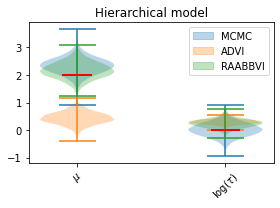

In [ ]:
plotResults('upper right')
plt.tight_layout()
plt.savefig('experiment1_hier.pdf')  

# Section 3: Simulation studies 

## Section 3.1: How well does the stopping criterion, that was proposed in the original ADVI paper work?

In [ ]:
# Run simulation expertiment: 
# Research question: How does standard ADVI compare against RAABBVI?
# This simulation compares the MAD for mean and std for linear regression  
# Note: For std the MCMC estimate is used as the ground truth
resultMu = {('beta', 'advi'): [],
          ('sigma', 'advi'): [],
          ('beta', 'raabbvi'): [],
          ('sigma', 'raabbvi'): []}

resDfMu = pd.DataFrame(resultMu)

resultStd = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfStd = pd.DataFrame(resultStd)


resultW = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfW = pd.DataFrame(resultW)

resultKS = {('beta', 'advi'): [],
              ('sigma', 'advi'): [],
              ('beta', 'raabbvi'): [],
              ('sigma', 'raabbvi'): []}

resDfKS = pd.DataFrame(resultKS)


for i in range(10):
  print('\nIteration: {} of 10'.format(i+1))
  print('-------------------------')
  N = 20
  y, sigma, theta, mu, tau = sample_data(N=N)

  with HiddenPrints():
    posterior_samples = run_mcmc(model, 10000, 10000, 1, sigma, y)
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 2000, 
                                            sigma, y, tol = 0.01, 
                                            stopping = 'ELBO')
    results, _ = raabbvi(N+2, log_density=log_density, num_mc_samples=1)
  resMu_i, resStd_i, resW_i, resKS_i = getPerformance(N+2)
  resDfMu = resDfMu.append(resMu_i)
  resDfStd = resDfStd.append(resStd_i)
  resDfW = resDfW.append(resW_i)
  resDfKS = resDfKS.append(resKS_i)

  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 1 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:26<00:00, 740.97it/s, 15 steps of size 2.29e-01. acc. prob=0.87]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 53.391 | R hat converged|:  19%|█▉        | 1938/10000 [00:04<00:20, 396.18it/s]
average loss = 52.098 | R hat converged|:  30%|██▉       | 2414/8061 [00:06<00:14, 398.41it/s]
average loss = 51.772 | R hat converged|: 100%|██████████| 5646/5646 [00:14<00:00, 383.43it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 2 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:27<00:00, 737.99it/s, 15 steps of size 3.72e-01. acc. prob=0.90]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 49.72 | R hat converged|:  18%|█▊        | 1797/10000 [00:04<00:21, 388.75it/s]
average loss = 48.026 | R hat converged|:  26%|██▌       | 2135/8202 [00:05<00:15, 387.11it/s]
average loss = 47.518 | R hat converged|:  76%|███████▌  | 4614/6066 [00:12<00:04, 355.55it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 3 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:29<00:00, 678.39it/s, 7 steps of size 4.19e-01. acc. prob=0.90]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 61.35 | R hat not converged|:  16%|█▌        | 1600/10000 [00:04<00:21, 399.76it/s]
average loss = 52.188 | R hat converged|:  33%|███▎      | 2811/8399 [00:07<00:14, 380.39it/s]
average loss = 51.645 | R hat converged|: 100%|██████████| 5587/5587 [00:14<00:00, 379.34it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 4 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:27<00:00, 731.74it/s, 15 steps of size 4.39e-01. acc. prob=0.87]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 57.13 | R hat converged|:  18%|█▊        | 1813/10000 [00:04<00:20, 390.45it/s]
average loss = 55.484 | R hat converged|:  35%|███▍      | 2857/8186 [00:07<00:13, 386.55it/s]
average loss = 54.922 | R hat converged|:  98%|█████████▊| 5216/5328 [00:13<00:00, 373.97it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 5 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:26<00:00, 749.21it/s, 15 steps of size 1.99e-01. acc. prob=0.91]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 54.858 | R hat converged|:  20%|██        | 2031/10000 [00:05<00:20, 392.79it/s]
average loss = 53.715 | R hat converged|:  28%|██▊       | 2202/7968 [00:05<00:14, 392.84it/s]
average loss = 53.314 | R hat converged|: 100%|██████████| 5765/5765 [00:15<00:00, 375.63it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 6 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:27<00:00, 728.12it/s, 15 steps of size 3.28e-01. acc. prob=0.88]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 50.045 | R hat converged|:  17%|█▋        | 1705/10000 [00:04<00:20, 397.93it/s]
average loss = 48.603 | R hat converged|:  29%|██▉       | 2392/8294 [00:06<00:15, 387.29it/s]
average loss = 47.933 | R hat converged|:  79%|███████▊  | 4638/5901 [00:12<00:03, 382.77it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 7 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:27<00:00, 719.21it/s, 7 steps of size 4.73e-01. acc. prob=0.90]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 53.781 | R hat converged|:  19%|█▉        | 1913/10000 [00:04<00:20, 394.69it/s]
average loss = 52.323 | R hat converged|:  39%|███▊      | 3120/8086 [00:08<00:12, 387.29it/s]
average loss = 51.694 | R hat converged|: 100%|██████████| 4965/4965 [00:13<00:00, 381.53it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 8 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:28<00:00, 709.75it/s, 15 steps of size 1.57e-01. acc. prob=0.96]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 45.494 | R hat converged|:  18%|█▊        | 1789/10000 [00:04<00:21, 382.18it/s]
average loss = 43.974 | R hat not converged|:  19%|█▉        | 1600/8210 [00:04<00:17, 386.53it/s]
average loss = 43.336 | R hat converged|:  67%|██████▋   | 4412/6609 [00:11<00:05, 378.90it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 9 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:27<00:00, 736.65it/s, 15 steps of size 4.75e-01. acc. prob=0.89]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 50.514 | R hat converged|:  17%|█▋        | 1696/10000 [00:04<00:21, 394.33it/s]
average loss = 48.922 | R hat not converged|:  29%|██▉       | 2400/8303 [00:06<00:15, 388.35it/s]
average loss = 48.185 | R hat converged|:  73%|███████▎  | 4305/5902 [00:11<00:04, 377.40it/s]
  0%|          | 0/20000 [00:00<?, ?it/s]


Iteration: 10 of 10
-------------------------


sample: 100%|██████████| 20000/20000 [00:29<00:00, 675.71it/s, 15 steps of size 3.40e-01. acc. prob=0.88]


  0%|          | 0/2000 [00:00<?, ?it/s]

average loss = 49.768 | R hat converged|:  17%|█▋        | 1701/10000 [00:04<00:20, 397.38it/s]
average loss = 47.89 | R hat converged|:  25%|██▌       | 2092/8298 [00:05<00:15, 388.05it/s]
average loss = 47.193 | R hat converged|:  57%|█████▋    | 3536/6205 [00:09<00:06, 385.06it/s]


In [ ]:
#Output for \mu-MAD
df = resDfMu.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_mu_MAD.txt', index = False)

#Output for \sigma-MAD
df = resDfStd.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_sigma_MAD.txt', index = False)

#Output for Wasserstein
df = resDfW.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(2).to_latex('sim1_W.txt', index = False)

#Output for KS
df = resDfKS.reindex(columns=['mu', 'logtau'], level=0)
df = df.apply(lambda x: np.mean(x), axis=0, result_type='broadcast').iloc[:1]
df.stack(level = 0).round(5).to_latex('sim1_KS.txt', index = False)

## Section 3.2: Is RAABBVI always better than ADVI or does it only depend on the stopping criteria?

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
result = dict()
times = dict()
simTotal = 10
maxLog2T = 10

timesteps = [2**i for i in range(maxLog2T)]

for nsim in range(simTotal):
  print(nsim)

  #Is RAABBVI always better than ADVI? Or does it just depand on the stopping criteria?
  N = 20
  y, sigma, theta, mu, tau = sample_data(N=N)
  k=0

  # Get MCMC perfomance
  posterior_samples = run_mcmc(model, 5000, 5000, 1, sigma, y)
  samples_mcmc = np.c_[posterior_samples['mu'].to_py(), 
                      posterior_samples['logtau'].to_py()]

  # Get RAABVI performance
  t0_raabbvi = time.time()
  results, _ = raabbvi(N+2, log_density=log_density, num_mc_samples=1)
  t_raabbvi = time.time()-t0_raabbvi

  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)
  samples_raabbvi= samples_raabbvi[:,0:2]

  # Get ADVI performance for different number of iterations
  for k in timesteps:
    vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 10000, 
                                                  sigma, y, stopping = 'time', tol = k)
    
    samplesVI = np.c_[vi_guide.sample_posterior(PRNGKey(1), 
                                                vi_params, 
                                                (2000,))['mu'].to_py(),
                      vi_guide.sample_posterior(PRNGKey(1), 
                                                vi_params, 
                                                (2000,))['logtau'].to_py()]   

    result[(k, nsim, 'ADVI', 'MAD', 'mu')], result[(k, nsim, 'ADVI', 'MAD', 'logtau')] = \
      MADstats(samplesVI, samples_mcmc, N+2)

    result[(k, nsim, 'ADVI', 'varErr', 'mu')], result[(k, nsim, 'ADVI', 'varErr', 'logtau')] = \
      varianceStats(samplesVI, samples_mcmc, N+2)

    result[(k, nsim, 'RAABBVI', 'MAD', 'mu')], result[(k, nsim, 'RAABBVI', 'MAD', 'logtau')] = \
      MADstats(samples_raabbvi, samples_mcmc, N+2)

    result[(k, nsim, 'RAABBVI', 'varErr', 'mu')], result[(k, nsim, 'RAABBVI', 'varErr', 'logtau')] = \
      varianceStats(samples_raabbvi, samples_mcmc, N+2)      

    result[(k, nsim, 'RAABBVI', 'time', '')] = t_raabbvi

    result[(k, nsim, 'ADVI', 'time', '')] = k

  #save results
  file_to_write = open("gdrive/My Drive/experiment1_results_hier.pickle", "wb")
  pickle.dump(result, file_to_write)


0


sample: 100%|██████████| 10000/10000 [00:15<00:00, 665.71it/s, 7 steps of size 3.19e-01. acc. prob=0.92]


Using cached StanModel for weighted_lin_regression


average loss = 49.036 | R hat converged|:  18%|█▊        | 1803/10000 [00:04<00:21, 386.46it/s]


Convergence reached at iteration 1803


average loss = 47.463 | R hat converged|:  29%|██▉       | 2393/8196 [00:06<00:15, 383.59it/s]


Convergence reached at iteration 2393


average loss = 47.108 | R hat converged|: 100%|██████████| 5802/5802 [00:15<00:00, 377.09it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 11 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 23 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 46 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 90 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 182 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 366 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 714 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1426 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2776 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 5035 iterations with time tol of 512.
1


sample: 100%|██████████| 10000/10000 [00:15<00:00, 633.12it/s, 7 steps of size 4.60e-01. acc. prob=0.89]


Using cached StanModel for weighted_lin_regression


average loss = 50.833 | R hat converged|:  18%|█▊        | 1790/10000 [00:04<00:22, 372.33it/s]


Convergence reached at iteration 1790


average loss = 49.425 | R hat converged|:  32%|███▏      | 2618/8209 [00:07<00:15, 372.23it/s]


Convergence reached at iteration 2618


average loss = 48.794 | R hat converged|:  95%|█████████▌| 5335/5590 [00:14<00:00, 366.86it/s]


Convergence reached at iteration 5335


Termination rule reached at iteration 9743
Inefficiency Index: 1.5117556025728849


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 20 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 40 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 75 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 157 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 318 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 634 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1238 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2510 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 4964 iterations with time tol of 512.
2


sample: 100%|██████████| 10000/10000 [00:15<00:00, 649.52it/s, 15 steps of size 2.99e-01. acc. prob=0.92]


Using cached StanModel for weighted_lin_regression


average loss = 47.581 | R hat converged|:  17%|█▋        | 1693/10000 [00:04<00:22, 371.03it/s]


Convergence reached at iteration 1693


average loss = 45.872 | R hat converged|:  35%|███▌      | 2940/8306 [00:07<00:14, 378.79it/s]


Convergence reached at iteration 2940


average loss = 45.169 | R hat converged|:  68%|██████▊   | 3639/5365 [00:09<00:04, 366.66it/s]


Convergence reached at iteration 3639


average loss = 44.887 | R hat not converged|: 100%|██████████| 1725/1725 [00:04<00:00, 382.91it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 21 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 41 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 81 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 156 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 316 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 631 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1248 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2483 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 4870 iterations with time tol of 512.
3


sample: 100%|██████████| 10000/10000 [00:15<00:00, 657.88it/s, 7 steps of size 4.10e-01. acc. prob=0.90]


Using cached StanModel for weighted_lin_regression


average loss = 46.331 | R hat converged|:  17%|█▋        | 1693/10000 [00:04<00:22, 370.28it/s]


Convergence reached at iteration 1693


average loss = 44.737 | R hat not converged|:  26%|██▋       | 2200/8306 [00:05<00:15, 382.63it/s]

Convergence reached at iteration 2200



average loss = 44.141 | R hat converged|:  72%|███████▏  | 4380/6105 [00:11<00:04, 372.47it/s]


Convergence reached at iteration 4380


Termination rule reached at iteration 8273
Inefficiency Index: 1.3812186773236543


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 21 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 41 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 80 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 160 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 318 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 627 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1237 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2466 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 4842 iterations with time tol of 512.
4


sample: 100%|██████████| 10000/10000 [00:15<00:00, 640.04it/s, 7 steps of size 4.40e-01. acc. prob=0.84]


Using cached StanModel for weighted_lin_regression


average loss = 54.245 | R hat converged|:  19%|█▉        | 1931/10000 [00:05<00:21, 381.24it/s]


Convergence reached at iteration 1931


average loss = 53.062 | R hat converged|:  30%|██▉       | 2402/8068 [00:06<00:14, 380.00it/s]

Convergence reached at iteration 2402



average loss = 52.766 | R hat converged|: 100%|██████████| 5665/5665 [00:17<00:00, 323.81it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 20 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 34 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 79 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 157 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 310 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 606 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1212 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2433 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 4893 iterations with time tol of 512.
5


sample: 100%|██████████| 10000/10000 [00:15<00:00, 651.09it/s, 15 steps of size 3.94e-01. acc. prob=0.88]


Using cached StanModel for weighted_lin_regression


average loss = 57.584 | R hat not converged|:  16%|█▌        | 1600/10000 [00:04<00:21, 384.26it/s]


Convergence reached at iteration 1600


average loss = 45.688 | R hat not converged|:  24%|██▍       | 2000/8399 [00:05<00:16, 383.87it/s]

Convergence reached at iteration 2000



average loss = 44.954 | R hat not converged|:  53%|█████▎    | 3400/6398 [00:09<00:07, 375.06it/s]

Convergence reached at iteration 3400


Termination rule reached at iteration 7000
Inefficiency Index: 1.0932295723437233


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 20 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 40 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 80 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 159 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 314 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 620 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1230 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2417 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 4808 iterations with time tol of 512.
6


sample: 100%|██████████| 10000/10000 [00:15<00:00, 636.56it/s, 7 steps of size 4.57e-01. acc. prob=0.88]


Using cached StanModel for weighted_lin_regression


average loss = 53.173 | R hat converged|:  19%|█▉        | 1903/10000 [00:05<00:21, 368.46it/s]


Convergence reached at iteration 1903


average loss = 51.764 | R hat converged|:  35%|███▌      | 2863/8096 [00:07<00:14, 369.14it/s]


Convergence reached at iteration 2863


average loss = 51.105 | R hat converged|:  86%|████████▋ | 4520/5232 [00:12<00:01, 366.68it/s]


Convergence reached at iteration 4520


Termination rule reached at iteration 9286
Inefficiency Index: 1.1669627744254312


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 21 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 40 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 79 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 151 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 310 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 617 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1233 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2454 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 4879 iterations with time tol of 512.
7


sample: 100%|██████████| 10000/10000 [00:15<00:00, 647.12it/s, 7 steps of size 3.56e-01. acc. prob=0.91]


Using cached StanModel for weighted_lin_regression


average loss = 54.918 | R hat converged|:  22%|██▏       | 2160/10000 [00:05<00:21, 368.53it/s]


Convergence reached at iteration 2160


average loss = 53.584 | R hat converged|:  51%|█████▏    | 4032/7839 [00:10<00:10, 371.01it/s]


Convergence reached at iteration 4032


average loss = 53.301 | R hat converged|: 100%|██████████| 3806/3806 [00:10<00:00, 368.98it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 20 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 40 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 79 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 158 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 316 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 620 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1236 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2436 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 4846 iterations with time tol of 512.
8


sample: 100%|██████████| 10000/10000 [00:15<00:00, 635.43it/s, 7 steps of size 4.17e-01. acc. prob=0.89]


Using cached StanModel for weighted_lin_regression


average loss = 57.816 | R hat converged|:  23%|██▎       | 2276/10000 [00:06<00:20, 369.21it/s]


Convergence reached at iteration 2276


average loss = 56.471 | R hat converged|:  40%|███▉      | 3087/7723 [00:08<00:12, 380.66it/s]

Convergence reached at iteration 3087



average loss = 56.08 | R hat converged|: 100%|██████████| 4635/4635 [00:12<00:00, 376.66it/s]


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 10 iterations with time tol of 1.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 21 iterations with time tol of 2.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 40 iterations with time tol of 4.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 80 iterations with time tol of 8.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 158 iterations with time tol of 16.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 318 iterations with time tol of 32.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 626 iterations with time tol of 64.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 1258 iterations with time tol of 128.


  0%|          | 0/10000 [00:00<?, ?it/s]

Stopped after 2494 iterations with time tol of 256.


  0%|          | 0/10000 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)
/usr/local/lib/python3.7/dist-packages/pandas/core/indexing.py:925: PerformanceWarning: indexing past lexsort depth may impact performance.
  return self._getitem_tuple(key)


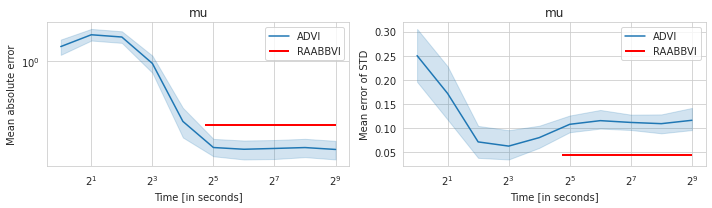

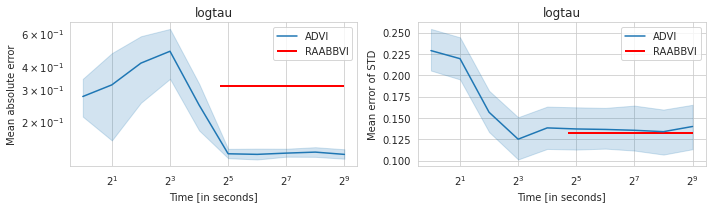

In [ ]:
file_res = open("gdrive/My Drive/experiment1_results_hier.pickle",'rb')
result = pickle.load(file_res)

df = pd.DataFrame(result).stack(level = [0,1])
df.index = df.index.droplevel(level = 0)
df.reset_index(inplace = True)

def plotSimulation1(colname, kpi, df, ax, time = True):
  dfMAD = df.loc[:, (slice(None), kpi, colname)]
  dfMAD.columns = [col[0] for col in dfMAD.columns]
  dfMAD = dfMAD.reset_index()
  dfMAD.drop(columns = ['index'], inplace = True)

  if time: 
    dfMAD['t_advi'] = df.loc[:, ('ADVI', 'time')].values
    dfMAD['t_raabbvi'] = df.loc[:, ('RAABBVI', 'time')].values

    tmin = dfMAD['t_advi'].min()
    tmax = dfMAD['t_advi'].max()

    sns.set_style('whitegrid')
    sns.lineplot(data = dfMAD, x = 't_advi', y = 'ADVI', ax = ax,
                 label = 'ADVI')

    t_RAABBVI = dfMAD['t_raabbvi'].mean()
    val_RAABBVI = dfMAD['RAABBVI'].mean()

    ax.hlines(y=val_RAABBVI, xmin=t_RAABBVI, xmax=dfMAD['t_advi'].max(), 
              linewidth=2, color='r', label = 'RAABBVI')

    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Time [in seconds]')
    ax.legend(loc="best")
    if kpi == 'MAD':   
      ax.set_ylabel('Mean absolute error')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('Mean error of STD')

  else:
    dfMAD['k'] = 2**df['level_0']

    dfMAD_melted = dfMAD.melt('k', var_name='Method', value_name=kpi)
    sns.set_style('whitegrid')

    sns.lineplot(data = dfMAD_melted, x = 'k', y = kpi, hue = 'Method', 
                      style = 'Method', ax = ax)
    ax.set_xscale('log', basex=2)
    ax.set_title(colname)
    ax.set_xlabel('Number of iterations')
    if kpi == 'MAD':   
      ax.set_ylabel('Mean absolute error')
      ax.set_yscale('log')
    if kpi == 'varErr':
      ax.set_ylabel('Mean error of STD')

sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
plotSimulation1('mu', 'MAD', df, ax[0])
plotSimulation1('mu', 'varErr', df, ax[1])
plt.tight_layout()
plt.savefig('gdrive/My Drive/experiment2_hier_mu.pdf')  

sns.set_style('whitegrid')
fig, ax = plt.subplots(ncols = 2, figsize=(10,3))
plotSimulation1('logtau', 'MAD', df, ax[0])
plotSimulation1('logtau', 'varErr', df, ax[1])
plt.tight_layout()
plt.savefig('gdrive/My Drive/experiment2_hier_logtau.pdf')  


## Section 3.3: Are there alternative stopping criteria for ADVI that match the performance of RAABBVI?

In [ ]:
# Run simulation with different stopping criteria: 
# 1: Relative improvement in ELBO 
# 2: PSIS k < 0.7 
# 3: Relative improvement in W2 bound 
# 4: RAABBVI 
# 5: MCMC
# Output: 

result = {}
for k in range(5):
  N = 20
  y, sigma, theta, mu, tau = sample_data(N=N)

  import warnings
  print('Inference using MCMC:')
  posterior_samples = run_mcmc(model, 10000, 10000, 1, sigma, y, False)
  samples_mcmc = np.c_[posterior_samples['mu'].to_py(), 
                      posterior_samples['logtau'].to_py()]

  print('---------------------\n')
  for rule in ['ELBO', 'PSIS', 'wasserstein', 'rhat']:
    print('Inference using ADVI with {}:'.format(rule))
    with warnings.catch_warnings():
      warnings.simplefilter("ignore")
      vi_losses, vi_params, vi_guide = run_ADVI(model, "AutoDiagonalNormal", 1000, 
                                                sigma, y, tol = 0.01, 
                                                stopping = rule)
      samplesVI = np.c_[vi_guide.sample_posterior(PRNGKey(1), 
                                                  vi_params, 
                                                  (2000,))['mu'].to_py(),
                        vi_guide.sample_posterior(PRNGKey(1), 
                                                  vi_params, 
                                                  (2000,))['logtau'].to_py()]   
      result[(k, 'MAD', 'mu', rule)], result[(k, 'MAD', 'logtau', rule)] = \
        MADstats(samplesVI, samples_mcmc, N+2)

      result[(k, 'varErr', 'mu', rule)], result[(k, 'varErr', 'logtau', rule)] = \
        varianceStats(samplesVI, samples_mcmc, N+2)

  print('---------------------\n')
  print('Inference using RAABBVI:')
  results, approx = raabbvi(N+2, log_density=log_density, num_mc_samples=1)
  samples_raabbvi = results['objective'].approx.sample(var_param = results['opt_param'],
                                                      n_samples = 2000)
  samples_raabbvi = samples_raabbvi[:,0:2]
  result[(k, 'MAD', 'mu', 'RAABBVI')], result[(k, 'MAD', 'logtau', 'RAABBVI')] = \
    MADstats(samples_raabbvi, samples_mcmc, N+2)

  result[(k, 'varErr', 'mu', 'RAABBVI')], result[(k, 'varErr', 'logtau', 'RAABBVI')] = \
    varianceStats(samples_raabbvi, samples_mcmc, N+2)

Inference using MCMC:


sample: 100%|██████████| 20000/20000 [00:26<00:00, 750.40it/s, 15 steps of size 3.40e-01. acc. prob=0.88]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 46 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 377 iterations because k = 0.78.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 38 iterations with W2 tol of 0.01.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 236 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 49.704 | R hat converged|:  17%|█▋        | 1694/10000 [00:04<00:20, 406.38it/s]


Convergence reached at iteration 1694


average loss = 47.881 | R hat converged|:  24%|██▍       | 1977/8305 [00:04<00:15, 406.95it/s]

Convergence reached at iteration 1977



average loss = 47.12 | R hat converged|:  59%|█████▊    | 3717/6327 [00:09<00:06, 390.45it/s]


Convergence reached at iteration 3717


Termination rule reached at iteration 7388
Inefficiency Index: 1.345636321831302
Inference using MCMC:


sample: 100%|██████████| 20000/20000 [00:26<00:00, 742.81it/s, 15 steps of size 2.32e-01. acc. prob=0.95]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 48 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 152 iterations because k = 0.80.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 182 iterations with W2 tol of 0.01.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 229 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 45.612 | R hat converged|:  18%|█▊        | 1802/10000 [00:04<00:20, 404.81it/s]


Convergence reached at iteration 1802


average loss = 44.053 | R hat not converged|:  29%|██▉       | 2400/8197 [00:05<00:14, 404.01it/s]


Convergence reached at iteration 2400


average loss = 43.428 | R hat converged|:  54%|█████▍    | 3134/5796 [00:07<00:06, 403.04it/s]


Convergence reached at iteration 3134


average loss = 43.384 | R hat not converged|: 100%|██████████| 2661/2661 [00:06<00:00, 415.41it/s]


Inference using MCMC:


sample: 100%|██████████| 20000/20000 [00:24<00:00, 818.96it/s, 15 steps of size 3.11e-01. acc. prob=0.87]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 20 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 398 iterations because k = 0.79.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 42 iterations with W2 tol of 0.01.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 274 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 52.868 | R hat converged|:  18%|█▊        | 1805/10000 [00:04<00:19, 418.86it/s]


Convergence reached at iteration 1805


average loss = 51.682 | R hat converged|:  38%|███▊      | 3103/8194 [00:07<00:12, 411.60it/s]


Convergence reached at iteration 3103


average loss = 51.302 | R hat converged|:  96%|█████████▋| 4903/5090 [00:11<00:00, 410.74it/s]

Convergence reached at iteration 4903


Termination rule reached at iteration 9811
Inefficiency Index: 1.1079559340121894
Inference using MCMC:


sample: 100%|██████████| 20000/20000 [00:23<00:00, 859.62it/s, 15 steps of size 2.86e-01. acc. prob=0.82]


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 25 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 324 iterations because k = 0.45.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 47 iterations with W2 tol of 0.01.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 256 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 52.518 | R hat converged|:  18%|█▊        | 1804/10000 [00:04<00:20, 407.92it/s]


Convergence reached at iteration 1804


average loss = 51.301 | R hat converged|:  35%|███▍      | 2861/8195 [00:07<00:13, 404.71it/s]

Convergence reached at iteration 2861



average loss = 50.935 | R hat not converged|: 100%|██████████| 5333/5333 [00:13<00:00, 401.79it/s]


Inference using MCMC:


sample: 100%|██████████| 20000/20000 [00:24<00:00, 823.73it/s, 7 steps of size 4.26e-01. acc. prob=0.91] 


---------------------

Inference using ADVI with ELBO:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 20 iterations with default tol of 0.01.
Inference using ADVI with PSIS:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 1 iterations because k = 0.35.
Inference using ADVI with wasserstein:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 44 iterations with W2 tol of 0.01.
Inference using ADVI with rhat:


  0%|          | 0/1000 [00:00<?, ?it/s]

Stopped after 102 iterations with rhat of 0.01.
---------------------

Inference using RAABBVI:
Using cached StanModel for weighted_lin_regression


average loss = 48.501 | R hat converged|:  17%|█▋        | 1693/10000 [00:04<00:20, 401.56it/s]


Convergence reached at iteration 1693


average loss = 46.725 | R hat converged|:  28%|██▊       | 2362/8306 [00:05<00:14, 404.97it/s]

Convergence reached at iteration 2362



average loss = 45.937 | R hat converged|:  57%|█████▋    | 3362/5943 [00:08<00:06, 402.31it/s]

Convergence reached at iteration 3362



average loss = 45.7 | R hat not converged|: 100%|██████████| 2580/2580 [00:06<00:00, 418.21it/s]


In [ ]:
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('MAD', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_mu.txt')
print(df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2))

print("-----")
df = pd.DataFrame(result).stack(level = 0)
df2 = pd.DataFrame(df.loc[:, ('varErr', slice(None), slice(None))].mean()).reset_index()
df2.columns = ['col'+str(i) for i in range(len(df2.columns))]
df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2).to_latex('experiment3_sigma.txt')
print(df2[['col1', 'col2', 'col3']].pivot(index="col1", columns="col2", values="col3").round(2))

col2    ELBO  PSIS  RAABBVI  rhat  wasserstein
col1                                          
logtau  0.59  0.36     0.51  0.23         0.51
mu      1.25  0.15     0.25  0.18         0.98
-----
col2    ELBO  PSIS  RAABBVI  rhat  wasserstein
col1                                          
logtau  0.31  0.27     0.25  0.26         0.26
mu      0.11  0.12     0.02  0.09         0.06
